In [ ]:
import numpy as np
import random, sys, io
import tensorflow as tf
from tensorflow.keras import layers, optimizers
from tensorflow.keras.utils import get_file
from tensorflow.keras.callbacks import LambdaCallback

In [ ]:
# (1) Google Drive에 저장된 파일 읽는 경우
from google.colab import drive
drive.mount('/content/gdrive')   # google drive를 google colab에 연결. 처음 실행 시, 인증 필요 
path = '/content/gdrive/My Drive/Colab Notebooks/ai/RNN/Gildong.txt'

# (2) Colab에 파일 업로드 시켜서 읽는 경우
# from google.colab import files
# path = files.upload()

# (3) Local PC에서 파일 읽는 경우 (동일 폴더 가정)
#path = 'Gildong.txt'

text = open(path).read()
print('corpus length:', len(text))
print(text[:100])

Mounted at /content/gdrive
corpus length: 23877
조선조 세종 때에 한 재상이 있었으니, 성은 홍씨요 이름은 아무였다. 대대 명문거족의 후예로서 어린 나이에 급제해 벼슬이 이조판서에까지 이르렀다. 물망이 조야에 으뜸인데다 충효까지


In [ ]:
chars = sorted(list(set(text)))
print('total chars:', len(chars))
for ch in chars:
    print(ch, end=",")
print()

total chars: 706

, ,!,",',(,),,,.,0,1,2,7,8,?,[,],《,》,㉰,仙,位,免,問,地,弔,恩,惡,文,書,檄,武,氣,物,石,童,臣,葬,藥,術,表,諭,謝,赦,雙,가,각,간,갈,감,갑,갔,강,갖,같,갚,개,객,거,건,걷,걸,검,겁,것,게,겠,겨,격,견,결,겼,경,곁,계,고,곡,곤,곧,골,곱,곳,공,과,관,광,괘,괴,굉,교,구,국,군,굳,굴,굽,궁,권,궐,귀,그,극,근,글,금,급,기,긴,길,김,깊,까,깎,깔,깝,깨,꺼,껄,껏,께,껴,꼬,꾀,꾸,꿇,꿈,끄,끊,끌,끓,끗,끝,끼,나,낙,난,날,남,납,났,낮,낳,내,낸,낼,냈,냐,냥,너,넋,넓,넘,넣,네,녀,년,념,노,논,놀,놈,농,높,놓,뇨,누,눈,느,는,늘,늙,능,니,닌,님,다,닥,닦,단,닫,달,닭,답,당,대,댁,더,덕,던,덜,덟,덩,데,도,독,돈,돌,동,되,된,될,두,둔,둘,뒤,뒷,드,득,든,듣,들,듬,듯,등,디,딜,따,딸,땅,때,떠,떤,떨,떻,떼,또,똘,뜨,뜬,뜰,뜸,뜻,띠,라,락,란,람,랍,랐,랑,래,랴,략,량,러,런,럼,럽,렀,렇,레,려,력,련,렵,렸,령,례,로,록,롭,롱,뢰,료,룡,루,룻,류,륜,륭,르,른,를,름,릉,리,린,릴,림,마,막,만,많,말,맑,망,맞,매,맨,맹,맺,머,먹,먼,멀,멋,며,면,멸,명,몇,모,목,몰,몸,몹,못,묘,무,묵,묶,문,묻,물,므,미,민,믿,밀,및,밑,바,박,밖,반,받,발,밝,밤,방,배,백,버,번,벌,범,법,벗,베,벼,벽,변,별,병,보,복,볶,본,볼,봉,봐,뵈,뵙,부,북,분,불,붉,붓,붙,비,빈,빌,빛,빠,빨,빼,뻐,뼈,뽐,뽑,뿐,쁘,쁜,사,산,살,삼,상,새,색,생,서,석,선,설,섬,성,세,셈,셋,셔,셨,소,속,손,솟,송,쇠,수,숙,순,술,숨,쉬,스,슨,슬,슴,습,승,시,식,신,실,싫,심,십,싶,싸,쌀,쌍,써,썩,썹,쏘,쏟,쓰,쓸,씀,씨,씩,아,악,안,앉,않,알,암,앗,았,앙,앞,애,앤,야,약,양,어,억,언,얻,얼,엄,업,없,엇,었,엎,에,여,역,연,열,염,였,영,예,옛,오,옥,온,올,옭,옮,옳,옵,와,완,왔,왕,외,왼,요,용,우,욱,운,울,움,웃,웅

In [ ]:
char_indices = dict((c,i) for i, c in enumerate(chars))
indices_char= dict((i,c) for i, c in enumerate(chars))

maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step): #range(start,stop,step)
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('num of sequences:', len(sentences))

print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
        #print(i,t,char)
    y[i, char_indices[next_chars[i]]]=1

num of sequences: 7946
Vectorization...


In [ ]:
def sample(preds, temperature=1.0):
    #helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def on_epoch_end(epoch, _):
    #Function invoked at end of each epoch. Prints generated text.
    print('----Generating text after Epoch: %d ' % epoch)
    start_index = random.randint(0, len(text) - maxlen - 1) #임의로 시작
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('---- diversity:', diversity)
        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        #텍스트의 임의의 부분부터 seed sentence로 시작
        print('----Generating with seed: "' + sentence + '""')
        sys.stdout.write(generated)
        
        for i in range(400):
            x_pred = np.zeros((1,maxlen,len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0,t,char_indices[char]] = 1      #seed sentence를 입력
    
            preds = model.predict(x_pred, verbose=0)[0] #후속 글자 예측
            ##후속 글자 확률이 나왔을 때, multinomial 분포로 랜덤하게 char 생성
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]
            generated += next_char
            sentence = sentence[1:] + next_char
    
            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

In [ ]:
# build the model: a single LSTM
model = tf.keras.Sequential()
model.add(layers.LSTM(128, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(0.01), loss='categorical_crossentropy')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               427520    
                                                                 
 dense (Dense)               (None, 706)               91074     
                                                                 
Total params: 518,594
Trainable params: 518,594
Non-trainable params: 0
_________________________________________________________________


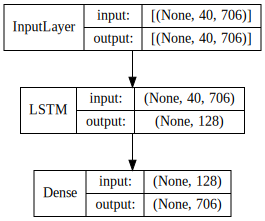

In [ ]:
# visualize model structure
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, show_layer_names=False, 
                 rankdir='TB', dpi=72).create(prog='dot', format='svg'))

In [ ]:
#training중 epoch 직후에 호출할 수 있는 함수 정의 기능
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

model.fit(x, y, batch_size=128, epochs=100,
         callbacks=[print_callback])

Epoch 1/100
63/63 [==============================] - ETA: 0s - loss: 4.5244----Generating text after Epoch: 0 
---- diversity: 0.2
----Generating with seed: "옵니다."
임금이 놀라 물었다.
"네가 깊은 밤에 어찌 왔느냐?"
길동이""
옵니다."
임금이 놀라 물었다.
"네가 깊은 밤에 어찌 왔느냐?"
길동이 ,  람 , ,                        , ,  아 , , , , ,  람 , ,  람  다 , , , ,  람 , ,  람                           , ,  람 , , , ,    , ,  람 , ,  람 ,  람 ,  람 , , 이                                                                         이  람 , ,  는 , 하고                         , ,  람                                                     , , , , ,  람 , ,  람 ,  람 , ,  람  람           이 , ,  었        , , ,  람 , ,
---- diversity: 0.5
----Generating with seed: "옵니다."
임금이 놀라 물었다.
"네가 깊은 밤에 어찌 왔느냐?"
길동이""
옵니다."
임금이 놀라 물었다.
"네가 깊은 밤에 어찌 왔느냐?"
길동이, 자니  때 올  다 있드  하 람 ,  제 , ,  놓    이 있 다. 말하, 하 ,, 말가,, 죄찌  이 , , ,  장 , 것  서  자  옵 ,  위 , , 다. 어도 ,  아 , 사려 , ,  아 , 이   다. 한장  진 하 , 이으 들 아      아게 이 여  모 ,  두  시 , 그 , , 서  은 ,  람이  아 , 길동  람  게 , ,  직 ,  람 , , 한 , , '찮 ,  동

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


길동을 잡아 올고, 모자와 차며 염려하고 나를 저이 올라가 외명을 듣고 먹지 못하여 어린 것이한진물을 어찌 자수이 없자하고 내려 나라 저어 세상을 떠나 선을 보고 야기를 재산 올 가도치 시했다.
"너는 어찌 이름은 소년이 지중하니다. 저물 부인에게 알고 싶었다. 인이 장성하여 부인은 재주를 알아 서 사람의 우리들이 들어가 아비의 하지 않가 있었다. 배가 올라는 약을 쓰는 것이니, 어찌 나른 받이 무수 생각하여 자기 자라 활상을
---- diversity: 0.5
----Generating with seed: "이 오늘 사은하고 나올 것이니 도끼와 칼을 쓰는 군사를 매복시켰다가 나오""
이 오늘 사은하고 나올 것이니 도끼와 칼을 쓰는 군사를 매복시켰다가 나오거기 길동은 이 한꺼어 밤이오."
다. 길동이 이루 아실니 없어 전상을 지만하여 소원이 조선을 마며 꾸짖고 못하여 금세하기 한 마음다. 아버지를 알고 이기를 원그 않가다."
그 아 가다 지신의 만일 나라가 나는 것이오."
그 날이 다. 무녀  잡아 올려니, 무슨 마음을 품을 와 퍼수 무녀 감이 수고 있었다. 배찍 가 보라 도 아버지를 알고 이기를 원입은 주가에 돌아오다.
"너는 어찌 놀라 나라는 공을 더고 길동을 잡아 올도드라는 아뢰었다.
"신이 말을 마치며 재주를 알고 말라."
부하들이 저 을 보고 먹이오."
그들이 함란 사람을 자랑 상가 지금이 만일 나라, 재를 생각하여 리상을 없왕하라는 여러 날 갑자기 돌아보면서 물지 흘 생각하되 도적을 잡아 올라가 임금이 진짜하길동이 아뢰었다.
"소인이 백성을 지만하
---- diversity: 1.0
----Generating with seed: "이 오늘 사은하고 나올 것이니 도끼와 칼을 쓰는 군사를 매복시켰다가 나오""
이 오늘 사은하고 나올 것이니 도끼와 칼을 쓰는 군사를 매복시켰다가 나오거야 소를 올어 여기에는 다만 팔도로 있어 들시을 힘아고 있루에면서
"소인에 도적이 계예로 어찌 날 였지 밤에면서 엎드시 아버리를 지다리라."
하고, 벌하지 못하여 금의 모은 